In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score,confusion_matrix,log_loss
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA,NMF

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor,DMatrix,plot_tree

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [2]:
train_df = pd.read_csv('train_df_final.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final_blanced.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
y = train_df['label'].values
y_org = train_df_org['label'].values

In [207]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
]

cat_features = []

In [208]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

In [209]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [210]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [211]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9637438	test: 0.9634802	best: 0.9634802 (0)	total: 19ms	remaining: 19s
10:	learn: 0.9706593	test: 0.9747052	best: 0.9749786 (9)	total: 117ms	remaining: 10.5s
20:	learn: 0.9737268	test: 0.9762337	best: 0.9763359 (19)	total: 199ms	remaining: 9.29s
30:	learn: 0.9750238	test: 0.9774249	best: 0.9774249 (30)	total: 300ms	remaining: 9.37s
40:	learn: 0.9757680	test: 0.9782713	best: 0.9783691 (39)	total: 381ms	remaining: 8.91s
50:	learn: 0.9766909	test: 0.9786337	best: 0.9787397 (46)	total: 524ms	remaining: 9.76s
60:	learn: 0.9773466	test: 0.9784297	best: 0.9787397 (46)	total: 608ms	remaining: 9.36s
70:	learn: 0.9778670	test: 0.9786214	best: 0.9787397 (46)	total: 691ms	remaining: 9.04s
80:	learn: 0.9782390	test: 0.9787152	best: 0.9789110 (77)	total: 811ms	remaining: 9.21s
90:	learn: 0.9785625	test: 0.9787071	best: 0.9790049 (82)	total: 930ms	remaining: 9.29s
100:	learn: 0.9789821	test: 0.9782171	best: 0.9790049 (82)	total: 1.01s	remaining: 9.02s
110:	le

In [212]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9566801773015498, 0.0053043619760975045, 0.9492484526967285)

In [213]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9557308157273616, 0.0029790683398620158, 0.9523343503540382)

In [214]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_duration,12.739150
1,fare_per_distance,11.010050
2,fare-additional_fare_per_distance,10.463529
3,fare-additional_fare_per_duration,10.081825
4,fare-additional_fare-meter_waiting_fare_per_du...,8.632382
5,fare-additional_fare-meter_waiting_fare_per_di...,7.469266
6,meter_waiting_per_duration,6.240614
7,addtional_fare_per_fare,4.155153
8,meter_waiting_till_pickup_per_meter_waiting,3.225367
9,avg_speed,3.210664


In [215]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89635854, 0.03560644],
       [0.10364146, 0.96439356]])

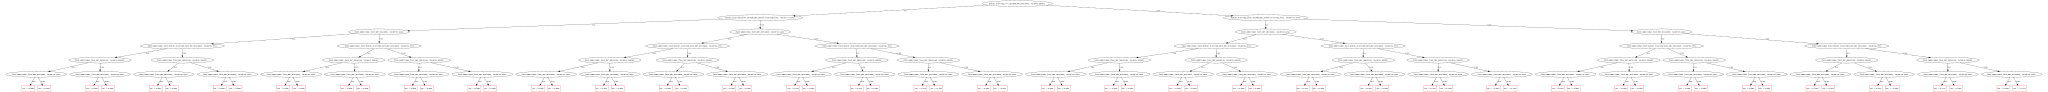

In [216]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

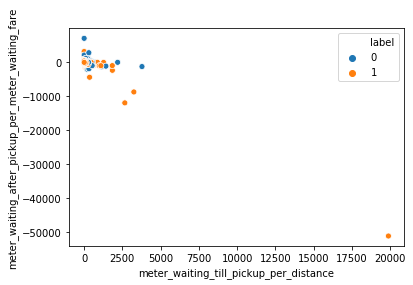

In [218]:
sns.scatterplot(x='meter_waiting_till_pickup_per_distance',y='meter_waiting_after_pickup_per_meter_waiting_fare',data=train_df,hue='label')

In [219]:
train_df[['meter_waiting_till_pickup_per_distance','meter_waiting_after_pickup_per_meter_waiting_fare']].describe()

,meter_waiting_till_pickup_per_distance,meter_waiting_after_pickup_per_meter_waiting_fare
count,16967.000000,16967.000000
mean,33.400572,5.019101
std,169.810214,442.471349
min,0.000000,-51208.000000
25%,4.942618,-23.520101
50%,15.012178,10.589172
75%,36.085880,16.722583
max,19889.333811,7084.000000


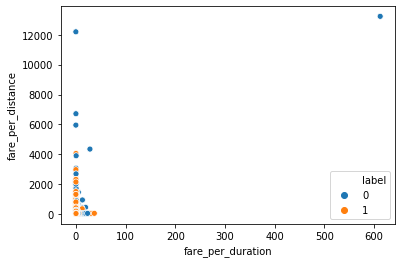

In [220]:
sns.scatterplot(x='fare_per_duration',y='fare_per_distance',data=train_df,hue='label')

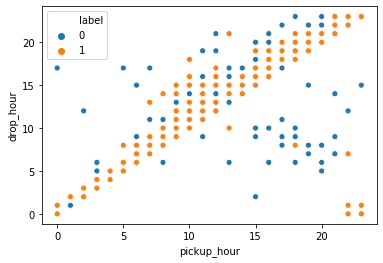

In [223]:
sns.scatterplot(x='pickup_hour',y='drop_hour',data=train_df,hue='label')

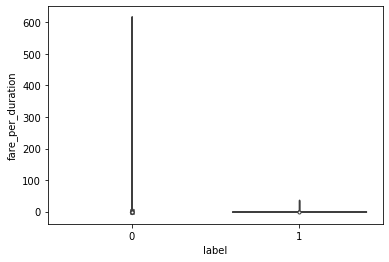

In [13]:
sns.violinplot(x='label',y='fare_per_duration',data=train_df)

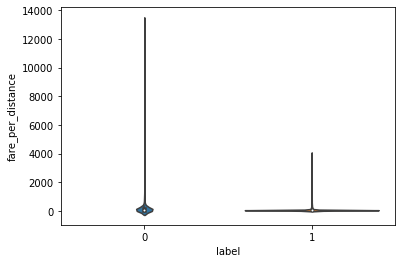

In [14]:
sns.violinplot(x='label',y='fare_per_distance',data=train_df)

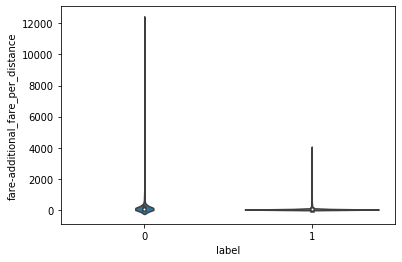

In [15]:
sns.violinplot(x='label',y='fare-additional_fare_per_distance',data=train_df)

# Col products

In [16]:
prod_cols = []
for i, col1 in enumerate(features):
    for col2 in features[i+1:]:
        name = f'{col1}@{col2}'
        train_df[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        train_df_org[name] = train_df_org[col1] * train_df_org[col2]
        prod_cols.append(name)

In [17]:
features = features + prod_cols

In [18]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [19]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [20]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9600914	test: 0.9607037	best: 0.9607037 (0)	total: 71.8ms	remaining: 1m 11s
10:	learn: 0.9692723	test: 0.9717868	best: 0.9717868 (10)	total: 582ms	remaining: 52.3s
20:	learn: 0.9731323	test: 0.9770905	best: 0.9772901 (19)	total: 1.1s	remaining: 51.5s
30:	learn: 0.9748892	test: 0.9780115	best: 0.9782068 (28)	total: 1.61s	remaining: 50.5s
40:	learn: 0.9760519	test: 0.9782837	best: 0.9782921 (35)	total: 2.12s	remaining: 49.6s
50:	learn: 0.9767486	test: 0.9786501	best: 0.9786582 (44)	total: 2.63s	remaining: 48.9s
60:	learn: 0.9776355	test: 0.9784586	best: 0.9788375 (54)	total: 3.14s	remaining: 48.4s
70:	learn: 0.9781455	test: 0.9780546	best: 0.9788375 (54)	total: 3.65s	remaining: 47.8s
80:	learn: 0.9787112	test: 0.9784379	best: 0.9788375 (54)	total: 4.17s	remaining: 47.3s
90:	learn: 0.9791796	test: 0.9783317	best: 0.9788375 (54)	total: 4.68s	remaining: 46.7s
100:	learn: 0.9797423	test: 0.9780336	best: 0.9788375 (54)	total: 5.19s	remaining: 46.2s
St

In [21]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9570338361990803, 0.004893219677337751, 0.950132625994695)

In [22]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9561913534051004, 0.0036502634882538388, 0.9512405733694088)

In [23]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance,7.650211
1,fare_per_distance@avg_speed,4.399818
2,fare_per_distance@fare-additional_fare_per_dis...,4.139117
3,fare_per_duration,3.686443
4,fare-additional_fare-meter_waiting_fare_per_di...,3.565296
...,...,...
248,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
249,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
250,meter_waiting_after_pickup_per_fare@meter_wait...,0.000000
251,meter_waiting_after_pickup_per_fare@meter_wait...,0.000000


In [24]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90222652, 0.03727877],
       [0.09777348, 0.96272123]])

In [25]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

submission_df['prediction'].sum() / submission_df.shape[0]

0.9465951492537313

## with 0 importance columns removed

In [25]:
model_1 = models[0]
df_1 = model_1.get_feature_importance(prettified=True)
set_1 = set(df_1[df_1['Importances'] == 0]['Feature Id'].values)

model_2 = models[1]
df_2 = model_2.get_feature_importance(prettified=True)
set_2 = set(df_2[df_2['Importances'] == 0]['Feature Id'].values)

model_3 = models[2]
df_3 = model_3.get_feature_importance(prettified=True)
set_3 = set(df_3[df_3['Importances'] == 0]['Feature Id'].values)

ignore = set_1.intersection(set_2,set_3)
ignore

{'addtional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
 'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_distance',
 'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_duration',
 'meter_waiting_till_pickup_per_fare@meter_waiting_after_pickup_per_meter_waiting_fare'}

In [26]:
features = [each for each in features if each not in ignore]

In [27]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [28]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [29]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9631838	test: 0.9618552	best: 0.9618552 (0)	total: 57.9ms	remaining: 57.9s
10:	learn: 0.9698033	test: 0.9741199	best: 0.9741199 (10)	total: 693ms	remaining: 1m 2s
20:	learn: 0.9733200	test: 0.9770949	best: 0.9770949 (18)	total: 1.34s	remaining: 1m 2s
30:	learn: 0.9749476	test: 0.9780199	best: 0.9780199 (30)	total: 1.98s	remaining: 1m 1s
40:	learn: 0.9760168	test: 0.9781092	best: 0.9781134 (31)	total: 2.61s	remaining: 1m 1s
50:	learn: 0.9768463	test: 0.9783773	best: 0.9784792 (45)	total: 3.27s	remaining: 1m
60:	learn: 0.9779668	test: 0.9782671	best: 0.9784792 (45)	total: 3.92s	remaining: 1m
70:	learn: 0.9786623	test: 0.9785482	best: 0.9788334 (68)	total: 4.57s	remaining: 59.8s
80:	learn: 0.9794648	test: 0.9785441	best: 0.9788334 (68)	total: 5.21s	remaining: 59.1s
90:	learn: 0.9798851	test: 0.9788253	best: 0.9789232 (88)	total: 5.85s	remaining: 58.4s
100:	learn: 0.9803565	test: 0.9787152	best: 0.9790089 (96)	total: 6.48s	remaining: 57.7s
110:	lea

In [30]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9561496941660819, 0.0058200147295376144, 0.9480106100795755)

In [31]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9563448659643466, 0.0010576642127316496, 0.9553278452593402)

In [32]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dis...,5.872666
1,fare-additional_fare_per_distance@fare-additio...,4.533409
2,avg_speed@fare-additional_fare-meter_waiting_f...,3.567931
3,fare_per_duration,3.089657
4,fare-additional_fare_per_distance,3.051817
...,...,...
244,meter_waiting_till_pickup_per_distance@meter_w...,0.000000
245,meter_waiting_after_pickup_per_distance@meter_...,0.000000
246,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
247,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000


In [33]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90644868, 0.03327871],
       [0.09355132, 0.96672129]])

# Log scale added

In [83]:
log_cols = []
for col in features:    
    name = f'log_{col}'
    train_df[name] = np.log(train_df[col] + 1)
    test_df[name] = np.log(test_df[col] + 1)
    train_df_org[name] = np.log(train_df_org[col] + 1)
    log_cols.append(name)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
features = features + log_cols

In [85]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [86]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [87]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9652889	test: 0.9706190	best: 0.9706190 (0)	total: 123ms	remaining: 2m 2s
10:	learn: 0.9706050	test: 0.9742371	best: 0.9742371 (10)	total: 1.26s	remaining: 1m 53s
20:	learn: 0.9728548	test: 0.9766333	best: 0.9766333 (20)	total: 2.3s	remaining: 1m 47s
30:	learn: 0.9746522	test: 0.9780199	best: 0.9780199 (30)	total: 3.34s	remaining: 1m 44s
40:	learn: 0.9760496	test: 0.9784751	best: 0.9784792 (37)	total: 4.32s	remaining: 1m 41s
50:	learn: 0.9769797	test: 0.9788416	best: 0.9788456 (49)	total: 5.42s	remaining: 1m 40s
60:	learn: 0.9778628	test: 0.9783525	best: 0.9789353 (51)	total: 6.62s	remaining: 1m 41s
70:	learn: 0.9783285	test: 0.9786214	best: 0.9789353 (51)	total: 7.77s	remaining: 1m 41s
80:	learn: 0.9790290	test: 0.9788091	best: 0.9789353 (51)	total: 8.9s	remaining: 1m 41s
90:	learn: 0.9793572	test: 0.9789888	best: 0.9789888 (88)	total: 10.1s	remaining: 1m 40s
100:	learn: 0.9796876	test: 0.9788868	best: 0.9791767 (96)	total: 11.3s	remaining: 1m

In [88]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9567979732797077, 0.006224076130129417, 0.9480106100795755)

In [89]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9544259589737685, 0.0010128484808317674, 0.9531402912900812)

In [90]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,log_fare_per_distance@fare-additional_fare_per...,3.283644
1,fare_per_distance@avg_speed,3.250897
2,log_fare-additional_fare_per_distance,3.174924
3,fare_per_distance@fare-additional_fare-meter_w...,2.718134
4,log_fare_per_duration@fare-additional_fare_per...,2.684101
...,...,...
501,log_meter_waiting_after_pickup_per_distance@me...,0.000000
502,log_meter_waiting_after_pickup_per_distance@me...,0.000000
503,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000
504,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000


In [91]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89711191, 0.03354562],
       [0.10288809, 0.96645438]])

## With 0 importance columns removed

In [92]:
model_1 = models[0]
df_1 = model_1.get_feature_importance(prettified=True)
set_1 = set(df_1[df_1['Importances'] == 0]['Feature Id'].values)

model_2 = models[1]
df_2 = model_2.get_feature_importance(prettified=True)
set_2 = set(df_2[df_2['Importances'] == 0]['Feature Id'].values)

model_3 = models[2]
df_3 = model_3.get_feature_importance(prettified=True)
set_3 = set(df_3[df_3['Importances'] == 0]['Feature Id'].values)

ignore = set_1.intersection(set_2,set_3)
ignore

{'addtional_fare_per_distance@meter_waiting_after_pickup_per_duration',
 'addtional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
 'addtional_fare_per_distance@meter_waiting_till_pickup_per_fare',
 'addtional_fare_per_duration@meter_waiting_after_pickup_per_distance',
 'addtional_fare_per_duration@meter_waiting_after_pickup_per_fare',
 'addtional_fare_per_duration@meter_waiting_till_pickup_per_distance',
 'addtional_fare_per_duration@meter_waiting_till_pickup_per_fare',
 'addtional_fare_per_fare@meter_waiting_after_pickup_per_duration',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_distance',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_duration',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_fare',
 'avg_speed@meter_waiting_till_pickup_per_fare',
 'avg_speed@meter_waiting_till_pickup_per_meter_waiting',
 'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
 'fare-additional_fare-meter

In [93]:
features = [each for each in features if each not in ignore]

In [94]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [95]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [96]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9664955	test: 0.9666698	best: 0.9666698 (0)	total: 81.9ms	remaining: 1m 21s
10:	learn: 0.9711758	test: 0.9749548	best: 0.9749548 (10)	total: 981ms	remaining: 1m 28s
20:	learn: 0.9734513	test: 0.9768952	best: 0.9772727 (19)	total: 2.02s	remaining: 1m 34s
30:	learn: 0.9749500	test: 0.9783045	best: 0.9784063 (29)	total: 3.08s	remaining: 1m 36s
40:	learn: 0.9763359	test: 0.9785687	best: 0.9786746 (37)	total: 4.07s	remaining: 1m 35s
50:	learn: 0.9769731	test: 0.9785482	best: 0.9787438 (48)	total: 5.04s	remaining: 1m 33s
60:	learn: 0.9776226	test: 0.9784462	best: 0.9787438 (48)	total: 6.06s	remaining: 1m 33s
70:	learn: 0.9787886	test: 0.9783317	best: 0.9787438 (48)	total: 6.94s	remaining: 1m 30s
80:	learn: 0.9791697	test: 0.9780420	best: 0.9787438 (48)	total: 7.96s	remaining: 1m 30s
90:	learn: 0.9795918	test: 0.9781358	best: 0.9787438 (48)	total: 9.01s	remaining: 1m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787437763
be

In [97]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9565622354202074, 0.0060473430438493835, 0.9480106100795755)

In [98]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9543875808339569, 0.0030898573803650564, 0.9503194980139312)

In [99]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance,4.235246
1,fare_per_duration,2.918840
2,fare_per_distance@fare-additional_fare_per_dis...,2.561977
3,log_fare_per_distance@avg_speed,2.289241
4,log_fare-additional_fare-meter_waiting_fare_pe...,1.756262
...,...,...
399,log_meter_waiting_till_pickup_per_distance@met...,0.000000
400,log_meter_waiting_after_pickup_per_distance@me...,0.000000
401,log_meter_waiting_after_pickup_per_distance@me...,0.000000
402,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000


In [100]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.91238938, 0.03125592],
       [0.08761062, 0.96874408]])

# PCA

In [301]:
n_components=40

In [302]:
X_train = train_df[features].values
X_train_org = train_df_org[features].values
X_test = test_df[features].values

In [303]:
pca = PCA(n_components=n_components)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
X_train_org_transformed = pca.transform(X_train_org)

In [304]:
pca_train = pd.DataFrame()
pca_train['label'] = train_df['label']

pca_train_org = pd.DataFrame()
pca_train_org['label'] = y_org

pca_test = pd.DataFrame()
for i in range(n_components):
    name = f'col_{i}'
    pca_train[name] = X_train_transformed[:,i]
    pca_test[name] = X_test_transformed[:,i]
    pca_train_org[name] = X_train_org_transformed[:,i]
    

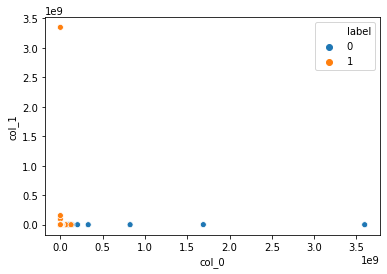

In [305]:
sns.scatterplot(x='col_0',y='col_1',data=pca_train,hue='label')

In [306]:
pca_cols = list(pca_test.columns)
for each in pca_cols:
    train_df[each] = pca_train[each]
    test_df[each] = pca_test[each]
    train_df_org[each] = pca_train_org[each]

In [307]:
features = features + pca_cols

In [308]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [309]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [310]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9662024	test: 0.9697434	best: 0.9697434 (0)	total: 65.5ms	remaining: 1m 5s
10:	learn: 0.9713228	test: 0.9746618	best: 0.9749261 (1)	total: 776ms	remaining: 1m 9s
20:	learn: 0.9730784	test: 0.9767176	best: 0.9769040 (18)	total: 1.51s	remaining: 1m 10s
30:	learn: 0.9753098	test: 0.9784833	best: 0.9784833 (30)	total: 2.25s	remaining: 1m 10s
40:	learn: 0.9764891	test: 0.9786623	best: 0.9786664 (32)	total: 3s	remaining: 1m 10s
50:	learn: 0.9774637	test: 0.9786501	best: 0.9788497 (41)	total: 3.71s	remaining: 1m 9s
60:	learn: 0.9782474	test: 0.9781609	best: 0.9788497 (41)	total: 4.45s	remaining: 1m 8s
70:	learn: 0.9789922	test: 0.9782379	best: 0.9788497 (41)	total: 5.2s	remaining: 1m 7s
80:	learn: 0.9794609	test: 0.9778502	best: 0.9788497 (41)	total: 5.92s	remaining: 1m 7s
90:	learn: 0.9801686	test: 0.9782254	best: 0.9788497 (41)	total: 6.66s	remaining: 1m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9788496507
bestIteration 

In [311]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9563265600906434, 0.00519109726489741, 0.9490716180371352)

In [312]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9525070519831904, 0.002609007931293489, 0.9493408554487364)

In [313]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dur...,6.175151
1,fare-additional_fare-meter_waiting_fare_per_di...,4.581372
2,fare_per_distance@fare-additional_fare-meter_w...,4.398438
3,avg_speed@fare-additional_fare_per_distance,4.236665
4,fare-additional_fare_per_distance@fare-additio...,4.058057
...,...,...
288,col_33,0.000000
289,col_36,0.000000
290,col_37,0.000000
291,col_38,0.000000


In [314]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90854271, 0.03894315],
       [0.09145729, 0.96105685]])

In [315]:
best_model.get_feature_importance(prettified=True)[:30]

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dur...,6.175151
1,fare-additional_fare-meter_waiting_fare_per_di...,4.581372
2,fare_per_distance@fare-additional_fare-meter_w...,4.398438
3,avg_speed@fare-additional_fare_per_distance,4.236665
4,fare-additional_fare_per_distance@fare-additio...,4.058057
5,fare_per_duration@fare-additional_fare_per_dis...,3.492866
6,fare_per_distance@avg_speed,3.301717
7,fare_per_distance,3.229522
8,fare_per_duration,2.821275
9,fare-additional_fare_per_duration@fare-additio...,2.767825


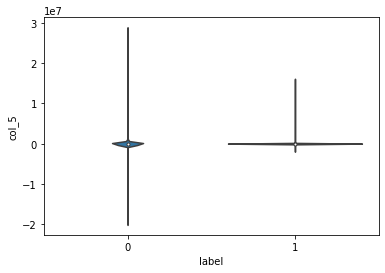

In [316]:
sns.violinplot(x='label',y='col_5',data=train_df)

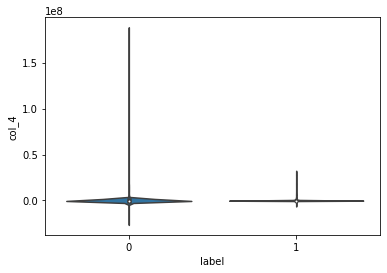

In [317]:
sns.violinplot(x='label',y='col_4',data=train_df)

In [26]:
train_df.to_csv('train_df_unit.csv',index=False)
test_df.to_csv('test_df_unit.csv',index=False)
train_df_org.to_csv('train_df_org_unit.csv',index=False)

# cal_time_difference_per_duration added

In [50]:
train_df = pd.read_csv('train_df_unit.csv')
test_df = pd.read_csv('test_df_unit.csv')
train_df_org = pd.read_csv('train_df_org_unit.csv')

In [51]:
train_df['cal_time_difference_per_duration'] = train_df['cal_time_difference'] / (train_df['duration']+1)
test_df['cal_time_difference_per_duration'] = test_df['cal_time_difference'] / (test_df['duration']+1)
train_df_org['cal_time_difference_per_duration'] = train_df_org['cal_time_difference'] / (train_df_org['duration']+1)

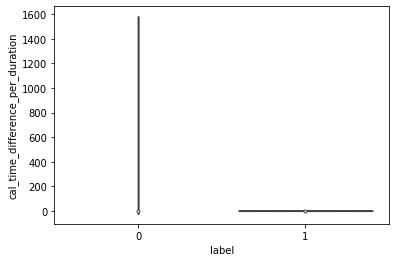

In [52]:
sns.violinplot(x='label',y='cal_time_difference_per_duration',data=train_df)

In [53]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare', 
    'cal_time_difference_per_duration',    
#     'fare_per_distance@fare_per_duration',    
#     'fare_per_distance@avg_speed',
#     'fare_per_distance@meter_waiting_per_duration',
#     'fare_per_distance@meter_waiting_fare_per_meter_waiting',
#     'fare_per_distance@meter_waiting_fare_per_duration',
#     'fare_per_distance@addtional_fare_per_fare',
#     'fare_per_distance@addtional_fare_per_distance',
#     'fare_per_distance@addtional_fare_per_duration',
#     'fare_per_distance@fare-additional_fare_per_distance',
#     'fare_per_distance@fare-additional_fare_per_duration',
#     'fare_per_distance@fare-additional_fare-meter_waiting_fare_per_distance',
#     'fare_per_distance@fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
#     'fare_per_distance@meter_waiting_after_pickup_per_duration',
#     'fare_per_distance@meter_waiting_till_pickup_per_duration',
#     'fare_per_distance@meter_waiting_till_pickup_per_distance',
#     'fare_per_distance@meter_waiting_after_pickup_per_distance',
#     'fare_per_distance@meter_waiting_till_pickup_per_fare',
#     'fare_per_distance@meter_waiting_after_pickup_per_fare',
#     'fare_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare_per_duration@avg_speed',
#     'fare_per_duration@meter_waiting_per_duration',
#     'fare_per_duration@meter_waiting_fare_per_meter_waiting',
#     'fare_per_duration@meter_waiting_fare_per_duration',
#     'fare_per_duration@addtional_fare_per_fare',
#     'fare_per_duration@addtional_fare_per_distance',
#     'fare_per_duration@addtional_fare_per_duration',
#     'fare_per_duration@fare-additional_fare_per_distance',
#     'fare_per_duration@fare-additional_fare_per_duration',
#     'fare_per_duration@fare-additional_fare-meter_waiting_fare_per_distance',
#     'fare_per_duration@fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'fare_per_duration@meter_waiting_after_pickup_per_duration',
#     'fare_per_duration@meter_waiting_till_pickup_per_duration',
#     'fare_per_duration@meter_waiting_till_pickup_per_distance',
#     'fare_per_duration@meter_waiting_after_pickup_per_distance',
#     'fare_per_duration@meter_waiting_till_pickup_per_fare',
#     'fare_per_duration@meter_waiting_after_pickup_per_fare',
#     'fare_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'avg_speed@meter_waiting_per_duration',
#     'avg_speed@meter_waiting_fare_per_meter_waiting',
#     'avg_speed@meter_waiting_fare_per_duration',
#     'avg_speed@addtional_fare_per_fare',
#     'avg_speed@addtional_fare_per_distance',
#     'avg_speed@addtional_fare_per_duration',
#     'avg_speed@fare-additional_fare_per_distance',
#     'avg_speed@fare-additional_fare_per_duration',
#     'avg_speed@fare-additional_fare-meter_waiting_fare_per_distance',
#     'avg_speed@fare-additional_fare-meter_waiting_fare_per_duration',
#     'avg_speed@meter_waiting_till_pickup_per_meter_waiting',
#     'avg_speed@meter_waiting_after_pickup_per_duration',
#     'avg_speed@meter_waiting_till_pickup_per_duration',
#     'avg_speed@meter_waiting_till_pickup_per_distance',
#     'avg_speed@meter_waiting_after_pickup_per_distance',
#     'avg_speed@meter_waiting_till_pickup_per_fare',
#     'avg_speed@meter_waiting_after_pickup_per_fare',
#     'avg_speed@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'avg_speed@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_per_duration@meter_waiting_fare_per_meter_waiting',
#     'meter_waiting_per_duration@meter_waiting_fare_per_duration',
#     'meter_waiting_per_duration@addtional_fare_per_fare',
#     'meter_waiting_per_duration@addtional_fare_per_distance',
#     'meter_waiting_per_duration@addtional_fare_per_duration',
#     'meter_waiting_per_duration@fare-additional_fare_per_distance',
#     'meter_waiting_per_duration@fare-additional_fare_per_duration',
#     'meter_waiting_per_duration@fare-additional_fare-meter_waiting_fare_per_distance',
#     'meter_waiting_per_duration@fare-additional_fare-meter_waiting_fare_per_duration',
#     'meter_waiting_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'meter_waiting_per_duration@meter_waiting_after_pickup_per_duration',
#     'meter_waiting_per_duration@meter_waiting_till_pickup_per_duration',
#     'meter_waiting_per_duration@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_per_duration@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_per_duration@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_per_duration@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_fare_per_duration',
#     'meter_waiting_fare_per_meter_waiting@addtional_fare_per_fare',
#     'meter_waiting_fare_per_meter_waiting@addtional_fare_per_distance',
#     'meter_waiting_fare_per_meter_waiting@addtional_fare_per_duration',
#     'meter_waiting_fare_per_meter_waiting@fare-additional_fare_per_distance',
#     'meter_waiting_fare_per_meter_waiting@fare-additional_fare_per_duration',
#     'meter_waiting_fare_per_meter_waiting@fare-additional_fare-meter_waiting_fare_per_distance',
#     'meter_waiting_fare_per_meter_waiting@fare-additional_fare-meter_waiting_fare_per_duration',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_meter_waiting',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_after_pickup_per_duration',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_duration',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_fare_per_meter_waiting@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_fare_per_duration@addtional_fare_per_fare',
#     'meter_waiting_fare_per_duration@addtional_fare_per_distance',
#     'meter_waiting_fare_per_duration@addtional_fare_per_duration',
#     'meter_waiting_fare_per_duration@fare-additional_fare_per_distance',
#     'meter_waiting_fare_per_duration@fare-additional_fare_per_duration',
#     'meter_waiting_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_distance',
#     'meter_waiting_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_duration',
#     'meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_duration',
#     'meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_duration',
#     'meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_fare@addtional_fare_per_distance',
#     'addtional_fare_per_fare@addtional_fare_per_duration',
#     'addtional_fare_per_fare@fare-additional_fare_per_distance',
#     'addtional_fare_per_fare@fare-additional_fare_per_duration',
#     'addtional_fare_per_fare@fare-additional_fare-meter_waiting_fare_per_distance',
#     'addtional_fare_per_fare@fare-additional_fare-meter_waiting_fare_per_duration',
#     'addtional_fare_per_fare@meter_waiting_till_pickup_per_meter_waiting',
#     'addtional_fare_per_fare@meter_waiting_after_pickup_per_duration',
#     'addtional_fare_per_fare@meter_waiting_till_pickup_per_duration',
#     'addtional_fare_per_fare@meter_waiting_till_pickup_per_distance',
#     'addtional_fare_per_fare@meter_waiting_after_pickup_per_distance',
#     'addtional_fare_per_fare@meter_waiting_till_pickup_per_fare',
#     'addtional_fare_per_fare@meter_waiting_after_pickup_per_fare',
#     'addtional_fare_per_fare@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_fare@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_distance@addtional_fare_per_duration',
#     'addtional_fare_per_distance@fare-additional_fare_per_distance',
#     'addtional_fare_per_distance@fare-additional_fare_per_duration',
#     'addtional_fare_per_distance@fare-additional_fare-meter_waiting_fare_per_distance',
#     'addtional_fare_per_distance@fare-additional_fare-meter_waiting_fare_per_duration',
#     'addtional_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
#     'addtional_fare_per_distance@meter_waiting_after_pickup_per_duration',
#     'addtional_fare_per_distance@meter_waiting_till_pickup_per_duration',
#     'addtional_fare_per_distance@meter_waiting_till_pickup_per_distance',
#     'addtional_fare_per_distance@meter_waiting_after_pickup_per_distance',
#     'addtional_fare_per_distance@meter_waiting_till_pickup_per_fare',
#     'addtional_fare_per_distance@meter_waiting_after_pickup_per_fare',
#     'addtional_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_duration@fare-additional_fare_per_distance',
#     'addtional_fare_per_duration@fare-additional_fare_per_duration',
#     'addtional_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_distance',
#     'addtional_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_duration',
#     'addtional_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'addtional_fare_per_duration@meter_waiting_after_pickup_per_duration',
#     'addtional_fare_per_duration@meter_waiting_till_pickup_per_duration',
#     'addtional_fare_per_duration@meter_waiting_till_pickup_per_distance',
#     'addtional_fare_per_duration@meter_waiting_after_pickup_per_distance',
#     'addtional_fare_per_duration@meter_waiting_till_pickup_per_fare',
#     'addtional_fare_per_duration@meter_waiting_after_pickup_per_fare',
#     'addtional_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'addtional_fare_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare-additional_fare_per_distance@fare-additional_fare_per_duration',
#     'fare-additional_fare_per_distance@fare-additional_fare-meter_waiting_fare_per_distance',
#     'fare-additional_fare_per_distance@fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare-additional_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
#     'fare-additional_fare_per_distance@meter_waiting_after_pickup_per_duration',
#     'fare-additional_fare_per_distance@meter_waiting_till_pickup_per_duration',
#     'fare-additional_fare_per_distance@meter_waiting_till_pickup_per_distance',
#     'fare-additional_fare_per_distance@meter_waiting_after_pickup_per_distance',
#     'fare-additional_fare_per_distance@meter_waiting_till_pickup_per_fare',
#     'fare-additional_fare_per_distance@meter_waiting_after_pickup_per_fare',
#     'fare-additional_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare-additional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare-additional_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_distance',
#     'fare-additional_fare_per_duration@fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare-additional_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_duration',
#     'fare-additional_fare_per_duration@meter_waiting_till_pickup_per_duration',
#     'fare-additional_fare_per_duration@meter_waiting_till_pickup_per_distance',
#     'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_distance',
#     'fare-additional_fare_per_duration@meter_waiting_till_pickup_per_fare',
#     'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_fare',
#     'fare-additional_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare-additional_fare-meter_waiting_fare_per_distance@fare-additional_fare-meter_waiting_fare_per_duration',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_after_pickup_per_duration',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_duration',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_distance',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_after_pickup_per_distance',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_fare',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_after_pickup_per_fare',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_duration',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_duration',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_distance',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_distance',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_fare',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_fare',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'fare-additional_fare-meter_waiting_fare_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_after_pickup_per_duration',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_till_pickup_per_duration',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_meter_waiting@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_till_pickup_per_duration',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_till_pickup_per_distance',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_duration@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_distance@meter_waiting_after_pickup_per_distance',
#     'meter_waiting_till_pickup_per_distance@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_till_pickup_per_distance@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_till_pickup_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_distance@meter_waiting_till_pickup_per_fare',
#     'meter_waiting_after_pickup_per_distance@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_after_pickup_per_distance@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_fare@meter_waiting_after_pickup_per_fare',
#     'meter_waiting_till_pickup_per_fare@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_fare@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_fare@meter_waiting_till_pickup_per_meter_waiting_fare',
#     'meter_waiting_after_pickup_per_fare@meter_waiting_after_pickup_per_meter_waiting_fare',
#     'meter_waiting_till_pickup_per_meter_waiting_fare@meter_waiting_after_pickup_per_meter_waiting_fare'
]

cat_features = []

In [54]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [55]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [56]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [57]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9673877	test: 0.9675405	best: 0.9675405 (0)	total: 22.3ms	remaining: 22.3s
10:	learn: 0.9708168	test: 0.9758233	best: 0.9758233 (10)	total: 164ms	remaining: 14.7s
20:	learn: 0.9730115	test: 0.9773877	best: 0.9773877 (20)	total: 274ms	remaining: 12.8s
30:	learn: 0.9748547	test: 0.9775528	best: 0.9776504 (28)	total: 379ms	remaining: 11.9s
40:	learn: 0.9764358	test: 0.9780924	best: 0.9781902 (39)	total: 490ms	remaining: 11.4s
50:	learn: 0.9768419	test: 0.9782713	best: 0.9782796 (41)	total: 592ms	remaining: 11s
60:	learn: 0.9773976	test: 0.9784545	best: 0.9785523 (55)	total: 736ms	remaining: 11.3s
70:	learn: 0.9774846	test: 0.9786378	best: 0.9787356 (69)	total: 830ms	remaining: 10.9s
80:	learn: 0.9781455	test: 0.9787193	best: 0.9788253 (72)	total: 914ms	remaining: 10.4s
90:	learn: 0.9783264	test: 0.9789968	best: 0.9789968 (90)	total: 1.04s	remaining: 10.4s
100:	learn: 0.9789801	test: 0.9790867	best: 0.9791847 (95)	total: 1.15s	remaining: 10.2s
110:

In [58]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9567980566529558, 0.005324574402133687, 0.9494252873563218)

In [59]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9542340682747108, 0.002123494070049288, 0.951931379886017)

In [60]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_duration,14.137234
1,fare_per_distance,9.586019
2,fare-additional_fare_per_duration,9.094066
3,fare-additional_fare_per_distance,8.362514
4,fare-additional_fare-meter_waiting_fare_per_di...,7.822463
5,fare-additional_fare-meter_waiting_fare_per_du...,6.530608
6,meter_waiting_per_duration,6.492305
7,meter_waiting_till_pickup_per_fare,4.700541
8,addtional_fare_per_fare,4.291016
9,addtional_fare_per_distance,3.808940


In [61]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89617486, 0.03415464],
       [0.10382514, 0.96584536]])

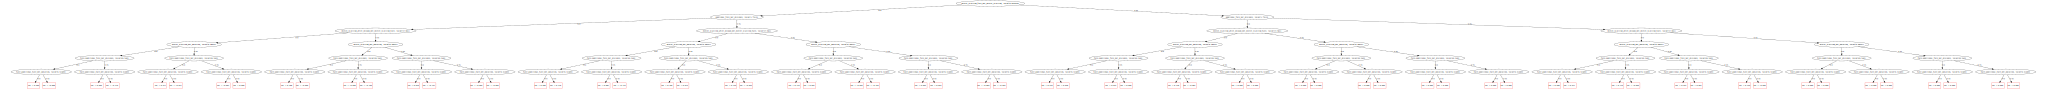

In [62]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

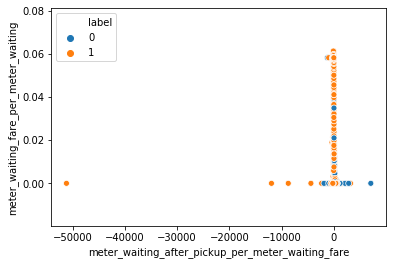

In [64]:
sns.scatterplot(x='meter_waiting_after_pickup_per_meter_waiting_fare',y='meter_waiting_fare_per_meter_waiting',data=train_df,hue='label')

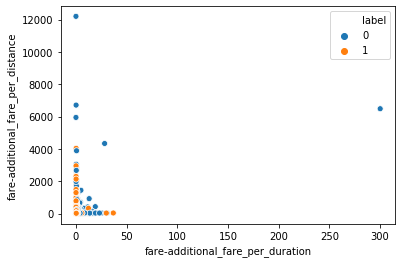

In [65]:
sns.scatterplot(x='fare-additional_fare_per_duration',y='fare-additional_fare_per_distance',data=train_df,hue='label')

# Date minute encoding

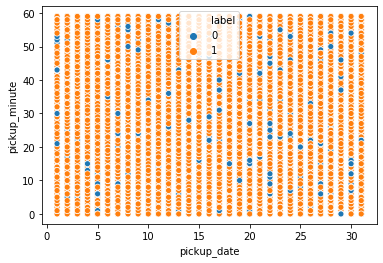

In [67]:
sns.scatterplot(x='pickup_date',y='pickup_minute',data=train_df,hue='label')

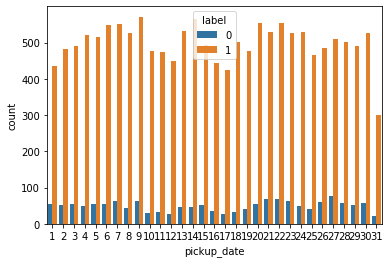

In [69]:
sns.countplot(x='pickup_date',data=train_df,hue='label')

In [92]:
def date_minute_encoding(by='pickup'):
    def f(row):
        date = f"{int(row[f'{by}_date']):02}"
        minute = f"{int(row[f'{by}_minute']):02}"
        return f'{date}_{minute}'
    return f

In [93]:
train_df['pickup_date_minute'] = train_df.apply(date_minute_encoding(),axis=1)
test_df['pickup_date_minute'] = test_df.apply(date_minute_encoding(),axis=1)
train_df_org['pickup_date_minute'] = train_df_org.apply(date_minute_encoding(),axis=1)

In [94]:
keys = list(train_df['pickup_date_minute'].unique())
keys.sort()
key_map = {}
for i, key in enumerate(keys):
    key_map[key] = i

In [100]:
def encode_with_key_map(key_map,col='pickup_date_minute'):
    def fn(row):
        key = row[col]
        return key_map[key]
    return fn

In [101]:
train_df['pickup_date_minute'] = train_df.apply(encode_with_key_map(key_map),axis=1)
test_df['pickup_date_minute'] = test_df.apply(encode_with_key_map(key_map),axis=1)
train_df_org['pickup_date_minute'] = train_df_org.apply(encode_with_key_map(key_map),axis=1)

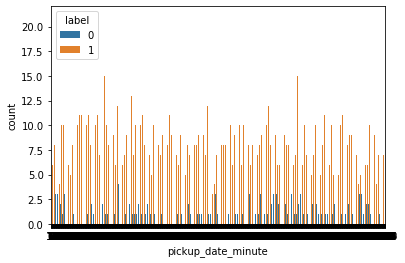

In [102]:
sns.countplot(x='pickup_date_minute',data=train_df,hue='label')

In [103]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare', 
    'cal_time_difference_per_duration',
    'pickup_date_minute'
]

cat_features = [
    'pickup_date_minute'
]

In [104]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [105]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [106]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [107]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9645110	test: 0.9633321	best: 0.9633321 (0)	total: 15.7ms	remaining: 15.7s
10:	learn: 0.9712742	test: 0.9733891	best: 0.9733891 (10)	total: 149ms	remaining: 13.4s
20:	learn: 0.9733612	test: 0.9761314	best: 0.9763268 (19)	total: 295ms	remaining: 13.7s
30:	learn: 0.9750405	test: 0.9765797	best: 0.9767664 (27)	total: 426ms	remaining: 13.3s
40:	learn: 0.9758565	test: 0.9773010	best: 0.9773010 (40)	total: 564ms	remaining: 13.2s
50:	learn: 0.9764734	test: 0.9782505	best: 0.9782546 (48)	total: 722ms	remaining: 13.4s
60:	learn: 0.9771240	test: 0.9786419	best: 0.9786419 (58)	total: 880ms	remaining: 13.6s
70:	learn: 0.9779201	test: 0.9784379	best: 0.9787316 (66)	total: 1.07s	remaining: 14s
80:	learn: 0.9784771	test: 0.9786173	best: 0.9787316 (66)	total: 1.3s	remaining: 14.7s
90:	learn: 0.9791836	test: 0.9785111	best: 0.9787316 (66)	total: 1.48s	remaining: 14.8s
100:	learn: 0.9795137	test: 0.9786907	best: 0.9788010 (92)	total: 1.65s	remaining: 14.7s
110:	

In [108]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9565033322203004, 0.005707795832522092, 0.9485411140583554)

In [109]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9551167654903766, 0.0014821615732986222, 0.9531402912900812)

In [110]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_duration,14.333870
1,fare_per_distance,9.996635
2,fare-additional_fare_per_distance,8.431726
3,fare-additional_fare_per_duration,7.305881
4,fare-additional_fare-meter_waiting_fare_per_du...,7.189087
5,fare-additional_fare-meter_waiting_fare_per_di...,7.020531
6,meter_waiting_per_duration,5.761711
7,addtional_fare_per_fare,4.093316
8,meter_waiting_till_pickup_per_fare,3.367971
9,addtional_fare_per_duration,3.218726


In [111]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90379523, 0.03170393],
       [0.09620477, 0.96829607]])

# Linear predictions

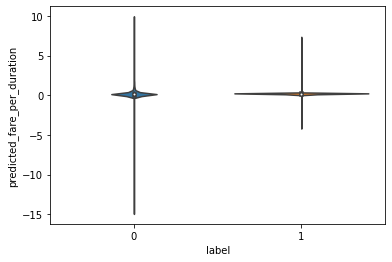

In [114]:
sns.violinplot(x='label',y='predicted_fare_per_duration',data=train_df)

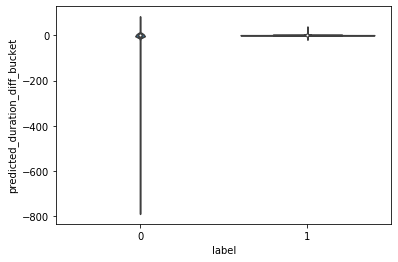

In [116]:
sns.violinplot(x='label',y='predicted_duration_diff_bucket',data=train_df)

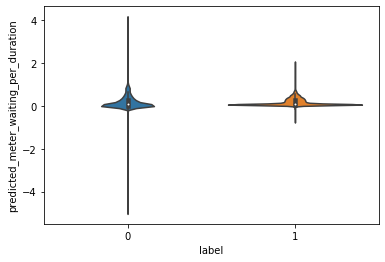

In [117]:
sns.violinplot(x='label',y='predicted_meter_waiting_per_duration',data=train_df)

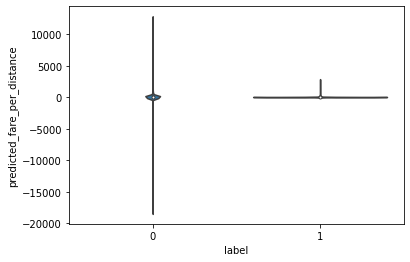

In [118]:
sns.violinplot(x='label',y='predicted_fare_per_distance',data=train_df)

In [119]:
predicted_cols = [
    'predicted_fare_per_duration',
    'predicted_duration_diff_bucket',
    'predicted_meter_waiting_per_duration',
    'predicted_fare_per_distance'
]

In [120]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare', 
    'cal_time_difference_per_duration'
]

cat_features = []

In [121]:
features = features + predicted_cols

In [122]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [123]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [124]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [125]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9672085	test: 0.9653217	best: 0.9653217 (0)	total: 17.8ms	remaining: 17.8s
10:	learn: 0.9732636	test: 0.9757865	best: 0.9757865 (10)	total: 151ms	remaining: 13.6s
20:	learn: 0.9750513	test: 0.9784792	best: 0.9784792 (20)	total: 262ms	remaining: 12.2s
30:	learn: 0.9761131	test: 0.9784545	best: 0.9786542 (26)	total: 354ms	remaining: 11.1s
40:	learn: 0.9770000	test: 0.9784338	best: 0.9786542 (26)	total: 446ms	remaining: 10.4s
50:	learn: 0.9774990	test: 0.9783234	best: 0.9786542 (26)	total: 553ms	remaining: 10.3s
60:	learn: 0.9781567	test: 0.9781190	best: 0.9786542 (26)	total: 647ms	remaining: 9.96s
70:	learn: 0.9781015	test: 0.9781064	best: 0.9786542 (26)	total: 738ms	remaining: 9.66s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9786541591
bestIteration = 26

Shrink model to first 27 iterations.
Learning rate set to 0.057693
0:	learn: 0.9725483	test: 0.9753855	best: 0.9753855 (0)	total: 10.7ms	remaining: 10.6s
10:	learn: 0.9

In [126]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9573874221450186, 0.005403670866170252, 0.9497789566755085)

In [127]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9514516531383723, 0.002679332938146988, 0.9481895112543895)

In [128]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff_bucket,11.999348
1,predicted_fare_per_duration,10.966978
2,fare_per_distance,8.542111
3,fare-additional_fare_per_duration,5.466479
4,fare-additional_fare-meter_waiting_fare_per_di...,5.406733
5,fare_per_duration,5.151288
6,addtional_fare_per_fare,4.477609
7,meter_waiting_till_pickup_per_fare,4.322477
8,fare-additional_fare_per_distance,4.097180
9,meter_waiting_till_pickup_per_duration,3.721779


In [129]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.9005425, 0.0334153],
       [0.0994575, 0.9665847]])

In [130]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

submission_df['prediction'].sum() / submission_df.shape[0]

0.9497434701492538

# Original noise cols

In [4]:
noise_cols = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup'
]

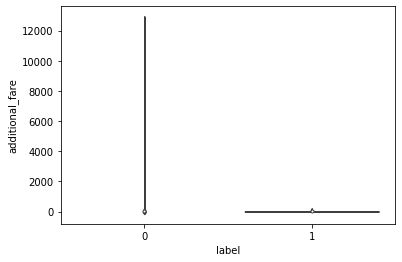

In [5]:
sns.violinplot(x='label',y='additional_fare',data=train_df)

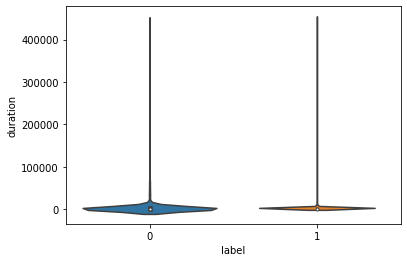

In [6]:
sns.violinplot(x='label',y='duration',data=train_df)

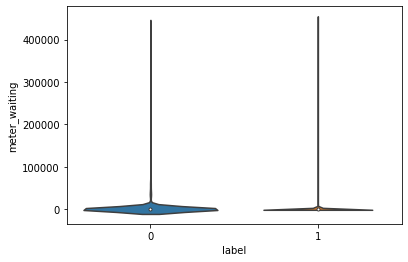

In [7]:
sns.violinplot(x='label',y='meter_waiting',data=train_df)

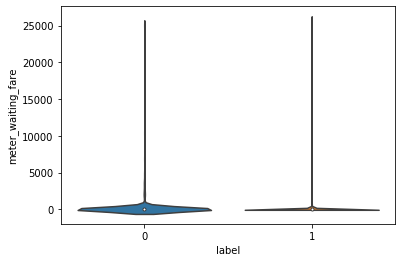

In [8]:
sns.violinplot(x='label',y='meter_waiting_fare',data=train_df)

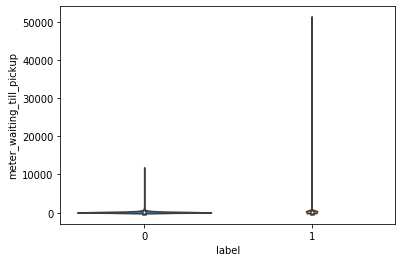

In [9]:
sns.violinplot(x='label',y='meter_waiting_till_pickup',data=train_df)

In [10]:
np.percentile(train_df['additional_fare'],0.99)

5.0

In [11]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
]

cat_features = []

In [12]:
features = features + noise_cols

In [13]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [14]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [15]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [16]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9689161	test: 0.9718567	best: 0.9718567 (0)	total: 65.3ms	remaining: 1m 5s
10:	learn: 0.9706356	test: 0.9743444	best: 0.9743444 (10)	total: 156ms	remaining: 14s
20:	learn: 0.9731528	test: 0.9770235	best: 0.9770235 (20)	total: 264ms	remaining: 12.3s
30:	learn: 0.9745444	test: 0.9772814	best: 0.9772814 (29)	total: 354ms	remaining: 11.1s
40:	learn: 0.9758864	test: 0.9779222	best: 0.9779222 (40)	total: 444ms	remaining: 10.4s
50:	learn: 0.9770439	test: 0.9780966	best: 0.9780966 (47)	total: 552ms	remaining: 10.3s
60:	learn: 0.9777799	test: 0.9782754	best: 0.9785646 (57)	total: 648ms	remaining: 9.97s
70:	learn: 0.9781008	test: 0.9782630	best: 0.9785646 (57)	total: 796ms	remaining: 10.4s
80:	learn: 0.9786073	test: 0.9785441	best: 0.9785646 (57)	total: 926ms	remaining: 10.5s
90:	learn: 0.9795938	test: 0.9784462	best: 0.9785646 (57)	total: 1.05s	remaining: 10.5s
100:	learn: 0.9800201	test: 0.9784297	best: 0.9785646 (57)	total: 1.15s	remaining: 10.2s
110:

In [17]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9563854945555185, 0.005243722097089282, 0.9490716180371352)

In [18]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9551551436301882, 0.001062527062338161, 0.9537159633872546)

In [19]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_duration,15.737274
1,fare_per_distance,9.748811
2,fare-additional_fare-meter_waiting_fare_per_di...,9.428255
3,fare-additional_fare_per_duration,8.762718
4,fare-additional_fare_per_distance,7.241807
5,meter_waiting_per_duration,6.138295
6,fare-additional_fare-meter_waiting_fare_per_du...,5.607462
7,additional_fare,3.552909
8,meter_waiting_till_pickup_per_duration,3.423581
9,duration,3.324484


In [20]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90232975, 0.03274241],
       [0.09767025, 0.96725759]])

# Orignial cat encodings

In [8]:
original_cat_cols = [
    'pickup_hour',
    'drop_hour',
#     'pick_cluster'
]

In [9]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
    'meter_waiting_till_pickup',
    
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    
    'predicted_duration_diff',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_distance',
]

cat_features = []

In [10]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [11]:
features += original_cat_cols
cat_features += original_cat_cols

In [12]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [13]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [14]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9677913	test: 0.9633578	best: 0.9633578 (0)	total: 63.5ms	remaining: 1m 3s
10:	learn: 0.9735162	test: 0.9748878	best: 0.9748974 (8)	total: 250ms	remaining: 22.5s
20:	learn: 0.9756377	test: 0.9769179	best: 0.9769179 (20)	total: 423ms	remaining: 19.7s
30:	learn: 0.9772586	test: 0.9772749	best: 0.9775690 (28)	total: 601ms	remaining: 18.8s
40:	learn: 0.9781337	test: 0.9781064	best: 0.9782045 (39)	total: 741ms	remaining: 17.3s
50:	learn: 0.9783172	test: 0.9781836	best: 0.9783799 (49)	total: 947ms	remaining: 17.6s
60:	learn: 0.9787908	test: 0.9782734	best: 0.9783799 (49)	total: 1.09s	remaining: 16.8s
70:	learn: 0.9792667	test: 0.9784491	best: 0.9784574 (62)	total: 1.33s	remaining: 17.4s
80:	learn: 0.9797408	test: 0.9781626	best: 0.9784574 (62)	total: 1.47s	remaining: 16.7s
90:	learn: 0.9801153	test: 0.9782567	best: 0.9784574 (62)	total: 1.67s	remaining: 16.7s
100:	learn: 0.9807369	test: 0.9779617	best: 0.9784574 (62)	total: 1.82s	remaining: 16.2s
110

In [15]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9579179365454543, 0.004541576619016016, 0.9515473032714412)

In [16]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9572659413198242, 0.00294675644795539, 0.9538310978066893)

In [17]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,12.982464
1,predicted_fare_diff_per_fare,11.612552
2,predicted_fare_diff_per_distance,8.969475
3,fare-additional_fare_per_distance,5.825993
4,fare_per_distance,5.034272
5,meter_waiting_till_pickup_per_meter_waiting,4.040724
6,fare_per_duration,3.930563
7,fare-additional_fare-meter_waiting_fare_per_di...,3.612823
8,avg_speed,3.603743
9,addtional_fare_per_distance,3.321062


In [18]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89455488, 0.03105629],
       [0.10544512, 0.96894371]])

In [19]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

submission_df['prediction'].sum() / submission_df.shape[0]

0.9453125

In [20]:
neumeric_cols_to_multiply = [
    'fare_per_distance',  
#     'fare_per_duration',
#     'fare-additional_fare_per_duration',
    'avg_speed',    
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_till_pickup'
]

encoding_cols = []
for col1 in original_cat_cols:
    for col2 in neumeric_cols_to_multiply:
        name = f'{col1}@{col2}'
        train_df[name] = train_df[col1] * train_df[col2]
        train_df_org[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        encoding_cols.append(name)

In [21]:
special_features = []
time_slot_neumerics = [
    'distance_km',
    'predicted_duration_diff',
    'predicted_fare_diff_per_distance',
    'meter_waiting_till_pickup'
]

for col in time_slot_neumerics:
    name = f'pickup_timeslot@{col}'
    train_df[name] = (train_df['pickup_timeslot']+1) * train_df[col]
    train_df_org[name] = (train_df_org['pickup_timeslot']+1) * train_df_org[col]
    test_df[name] = (test_df['pickup_timeslot']+1) * test_df[col]
    special_features.append(name)



In [22]:
features += encoding_cols
features += special_features

In [23]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [24]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [25]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
train_pools = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    train_pools.append(train_pool)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9686891	test: 0.9681275	best: 0.9681275 (0)	total: 29.7ms	remaining: 29.6s
10:	learn: 0.9740538	test: 0.9761223	best: 0.9761223 (10)	total: 211ms	remaining: 18.9s
20:	learn: 0.9755911	test: 0.9780588	best: 0.9780588 (20)	total: 393ms	remaining: 18.3s
30:	learn: 0.9767887	test: 0.9780251	best: 0.9782254 (25)	total: 575ms	remaining: 18s
40:	learn: 0.9777181	test: 0.9782943	best: 0.9784905 (37)	total: 785ms	remaining: 18.4s
50:	learn: 0.9782275	test: 0.9788624	best: 0.9788624 (50)	total: 962ms	remaining: 17.9s
60:	learn: 0.9786520	test: 0.9782734	best: 0.9788624 (50)	total: 1.15s	remaining: 17.7s
70:	learn: 0.9794136	test: 0.9780727	best: 0.9788624 (50)	total: 1.34s	remaining: 17.5s
80:	learn: 0.9799328	test: 0.9780600	best: 0.9788624 (50)	total: 1.54s	remaining: 17.4s
90:	learn: 0.9803620	test: 0.9782483	best: 0.9788624 (50)	total: 1.72s	remaining: 17.2s
100:	learn: 0.9808367	test: 0.9782441	best: 0.9788624 (50)	total: 1.92s	remaining: 17.1s
Stop

In [28]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9577410914642052, 0.004880367371053663, 0.9508399646330681)

In [29]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9536200180377258, 0.002505478286638588, 0.9513557077888435)

In [30]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_duration_diff,13.023231
1,predicted_fare_diff_per_predicted_fare,9.263556
2,predicted_fare_diff_per_distance,8.683698
3,predicted_fare_diff_per_fare,8.164132
4,fare-additional_fare_per_distance,6.499079
5,fare_per_duration,4.558730
6,fare-additional_fare-meter_waiting_fare_per_di...,4.416574
7,fare_per_distance,3.839422
8,meter_waiting_per_duration,3.609171
9,pickup_timeslot@distance_km,2.940554


In [31]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.88878843, 0.03423492],
       [0.11121157, 0.96576508]])

In [32]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

submission_df['prediction'].sum() / submission_df.shape[0]

0.9464785447761194

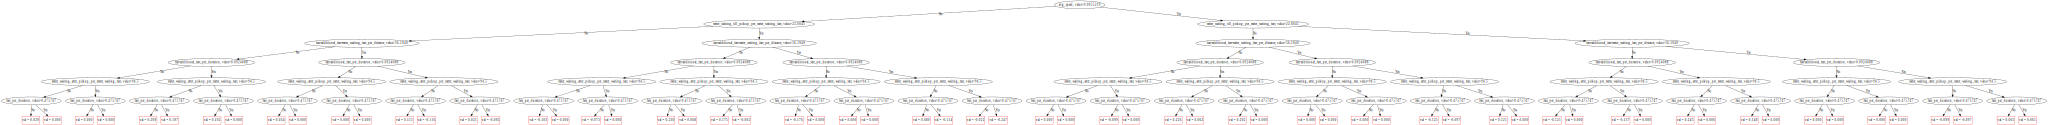

In [111]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

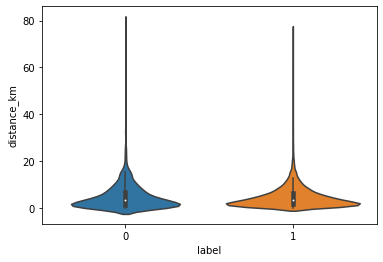

In [114]:
sns.violinplot(x='label',y='distance_km',data=train_df)

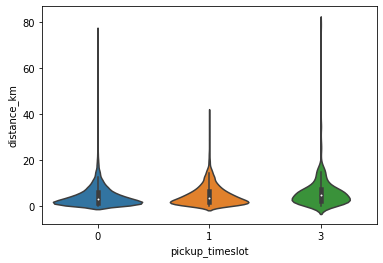

In [116]:
sns.violinplot(x='pickup_timeslot',y='distance_km',data=train_df)

In [118]:
train_df['pickup_timeslot@distance'] = (train_df['pickup_timeslot']+1) * train_df['distance_km']

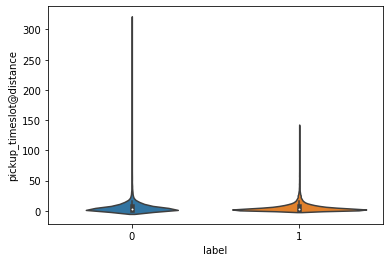

In [119]:
sns.violinplot(x='label',y='pickup_timeslot@distance',data=train_df)

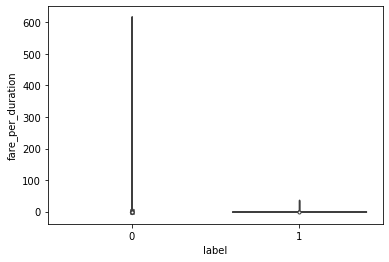

In [115]:
sns.violinplot(x='label',y='fare_per_duration',data=train_df)

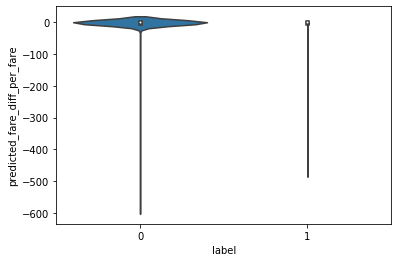

In [30]:
sns.violinplot(x='label',y='predicted_fare_diff_per_distance',data=train_df)

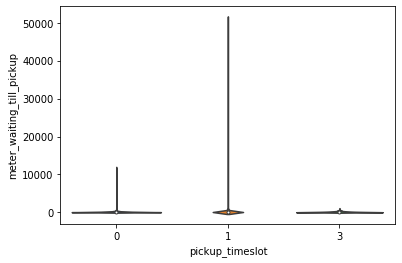

In [7]:
sns.violinplot(x='pickup_timeslot',y='meter_waiting_till_pickup',data=train_df)

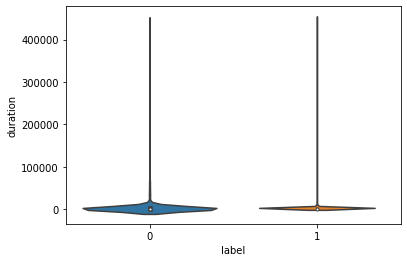

In [35]:
sns.violinplot(x='label',y='duration',data=train_df)